This code is written to generate synthetic data to learn a ROM for a chaotic 1D fault earthquake sequence.

Steps:
* import functions.
* apply/load POD.


    1- To apply the POD, you can apply it seperately on v and theta or you can apply it all together

    
* randomly sample initial condition.
* save the output.


In [1]:
import numpy as np
import cte_eq
import sys
sys.path.append('./..')
import cte
import matplotlib.pyplot as plt
from ProcessFunctions import Ploteigs,ApplyPODStateSpace2D,GenRandom_ai,FindInitFromAi
from Forward2d import forwardmodel

In [2]:
index=0
np.random.seed(index)  # seed is set using the index

In [3]:
# load the long simulation.
drs=0.012
T_final_load=10500
ApplyPOD=True # 1 if you want to apply POD, 0 if you want to load the data
Nxout=cte_eq.Nxout
Ntout=cte_eq.Ntout
T_filter=5500 




In [4]:
if ApplyPOD:
    direct='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/2DSim_MainSimulation_Tf'+str(T_final_load)+"Nx="+str(Nxout)+"Nt="+str(Ntout)+'drs'+str(drs)+".npz"
    data=np.load(direct)
    v=data['v']
    theta=data['theta']
    dc=data['dc']
    t=data['t']
    Nx=dc.shape[0]//cte_eq.Nxout
    U,S,VT,q_bar=ApplyPODStateSpace2D(v,theta,t,T_filter,Nx)
    # saving U,S,VT,q_bar to later use in if ApplyPOD==0
    np.savez('/central/groups/astuart/hkaveh/Data/LearnROM/transfer/'+str(T_final_load)+"Nx="+str(Nxout)+"Nt="+str(Ntout)+'drs'+str(drs),U=U,S=S,VT=VT,q_bar=q_bar)
else:
    # load U,S,VT,q_bar
    data=np.load('/central/groups/astuart/hkaveh/Data/LearnROM/transfer/'+str(T_final_load)+"Nx="+str(Nxout)+"Nt="+str(Ntout)+'drs'+str(drs)+'.npz')
    U=data['U']
    S=data['S']
    VT=data['VT']
    q_bar=data['q_bar']
    



678


In [5]:
Nt2=VT.shape[0] # number of snapshots in the dataset after filtering first T_filter years
Nx=U.shape[0]//2

In [6]:
Nx

1024

In [7]:
N_m=30
coeff=1
Specifyinit=True
T_final_run=350 # The interevent time is 34 years, how many events you want to include? I think 10 events is good
ai=GenRandom_ai(U,S,N_m,Nt2,coeff)
print(ai)
u_init=FindInitFromAi(ai,U,N_m,q_bar)
print(u_init.shape)
v0=10**(u_init[:Nx])
v0max=np.max(v0)
while v0max>1e2: # making sure the initial condition is somewhere that has less than 1e3 maximum slip rate
    ai=GenRandom_ai(U,S,N_m,Nt2,coeff)
    u_init=FindInitFromAi(ai,U,N_m,q_bar)
    v0=10**(u_init[:Nx])
    print(u_init[0])
    v0=10**(u_init[:Nx])
    v0max=np.max(v0)

[[ 1.10142226e+02  1.23536329e+01  2.10964148e+01  3.37176450e+01
   2.26840307e+01 -1.15322570e+01  8.11653183e+00 -1.09206802e+00
  -6.48784246e-01  2.35894418e+00  7.40781101e-01  6.71417028e+00
   3.29303653e+00  4.86428961e-01  1.55254360e+00  1.15106965e+00
   4.76496246e+00 -5.87289259e-01  8.77837743e-01 -2.33357730e+00
  -6.68411871e+00  1.59222060e+00  1.96835161e+00 -1.61142639e+00
   4.75703270e+00 -2.91550066e+00  8.73326831e-02 -3.48840066e-01
   2.73518346e+00  2.46403896e+00]]
(2048, 1)


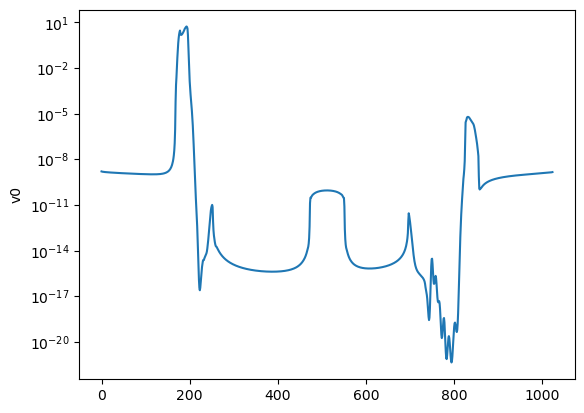

In [8]:
plt.plot(10**(u_init[:Nx]))
plt.yscale("log")
plt.ylabel('v0')
plt.savefig('v0.png')

In [15]:
L

NameError: name 'L' is not defined

In [23]:
from scipy.interpolate import interp1d


In [19]:
v_init_lowres=u_init[:Nx]
theta_init_lowres=u_init[Nx:]
x_lowres=np.linspace(-cte_eq.L,cte_eq.L,Nx)
x_highres=np.linspace(-cte_eq.L,cte_eq.L,Nx*cte_eq.Nxout)

In [21]:
v_init_lowres.shape

(1024, 1)

In [28]:
v_interp = interp1d(x_lowres, v_init_lowres.flatten(), kind='linear', fill_value="extrapolate")
theta_interp = interp1d(x_lowres, theta_init_lowres.flatten(), kind='linear', fill_value="extrapolate")

# Interpolated high-res fields
v_init_highres = v_interp(x_highres).reshape(-1, 1)
theta_init_highres = theta_interp(x_highres).reshape(-1, 1)
# Combine into new u_init
u_init_highres = np.vstack([v_init_highres, theta_init_highres])

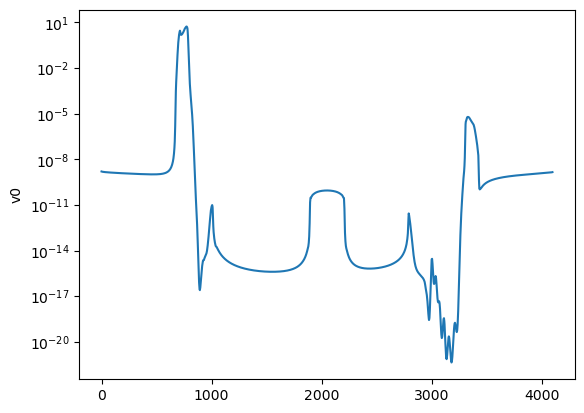

In [34]:
plt.plot(10**v_init_highres)
plt.yscale("log")
plt.ylabel('v0')


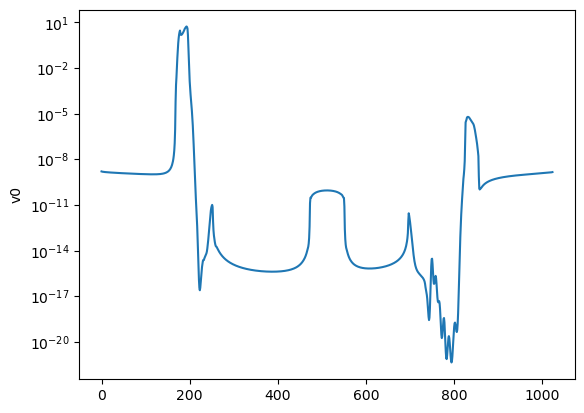

In [33]:
plt.plot(10**v_init_lowres)
plt.yscale("log")
plt.ylabel('v0')


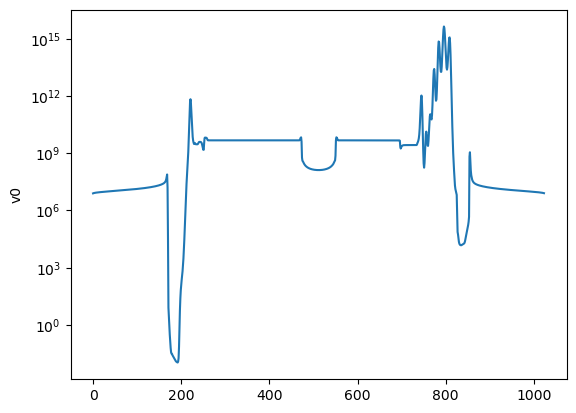

In [32]:
plt.plot(10**theta_init_lowres)
plt.yscale("log")
plt.ylabel('theta0')


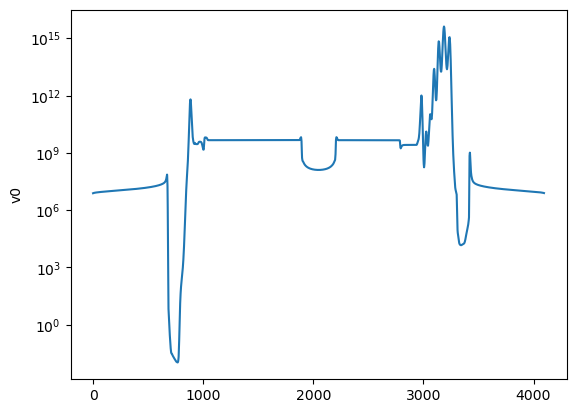

In [31]:
plt.plot(10**theta_init_highres)
plt.yscale("log")
plt.ylabel('theta0')


In [35]:
p=forwardmodel(T_final_run,cte_eq.Ntout,cte_eq.Nxout,Specifyinit,u_init_highres,drs)

Number of elements 4096
 Number of processors =            1
 Start reading input ...
    Mesh input complete
   Flags input complete
 Input complete
 Initializing mesh ...
 1D fault, uniform grid
 Impedance =    4545454.5454545459     
 Intializing kernel: ...
 FFT applied
 Reading kernel /central/groups/astuart/hkaveh/QDYN/qdyn-read-only/src/kernel_I.tab
 Kernel intialized
 Values at selected point of the fault:
 K/Kc =   -4.7123889803846894E-002
 K/Kb =    1.1780972450961723E-002

     it,  dt (secs), time (yrs), v_max (m/s), sigma_max (MPa)
 Initialising RK45 solver
 Finished initialising RK45 solver
 Initialization completed
      0   0.000E+00   0.000E+00   0.541E+01   0.500E+02
     50   0.700E-03   0.721E-09   0.524E+01   0.500E+02
    100   0.107E-02   0.221E-08   0.456E+01   0.500E+02
    150   0.116E-02   0.400E-08   0.397E+01   0.500E+02
    200   0.120E-02   0.586E-08   0.350E+01   0.500E+02
    250   0.121E-02   0.775E-08   0.313E+01   0.500E+02
    300   0.122E-02   0.96

KeyboardInterrupt: 

In [ ]:
direct='./Data/SampleSimulation_Tf_2D'+str(T_final_run)+"Nt="+str(cte_eq.Ntout)+"N_m"+str(N_m)+"coeff"+str(coeff)+"number"+str(index)
# You only need time, V, theta, so only saving those:
x_ox=p.ox["x"].unique()
Nt=len(p.ox["v"])//(len(x_ox)) # Number of Snapshots
t_ox=p.ox["t"].values.reshape((Nt,len(x_ox)))
V_ox=p.ox["v"].values.reshape((Nt,len(x_ox)))
theta_ox=p.ox["theta"].values.reshape((Nt,len(x_ox)))
np.savez_compressed(direct+'.npz', array1=V_ox, array2=theta_ox, array3=t_ox)


FileNotFoundError: [Errno 2] No such file or directory: './Data/SampleSimulation_Tf_2D350Nt=1500N_m30coeff1number35.npz'